# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
try:
    import ipywidgets
except:
    %pip install ipywidgets
    # exit(0) # Kernel needs to be restarted to use ipywidgets

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    # Values (0.5,), (0.5,) taken from `https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627`
    transforms.Normalize((0.5,), (0.5,)), 
])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST('.pytorch/MNIST_data/train', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST('.pytorch/MNIST_data/test', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

First we converted the image into numbers using transforms.ToTensor(), as the network can only take numbers as input
Then we normalizes the tensor with a mean and standard deviation of 0.5, 0.5 respectively. This will make the data within a range and reduces the skewness, which helps learn faster and better

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


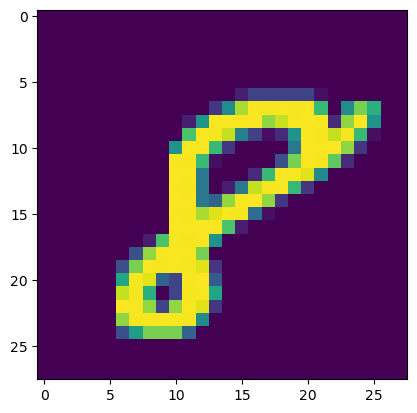

9


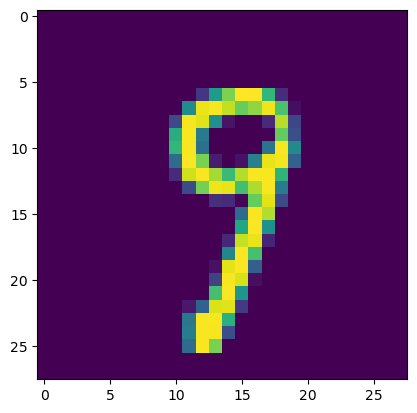

1


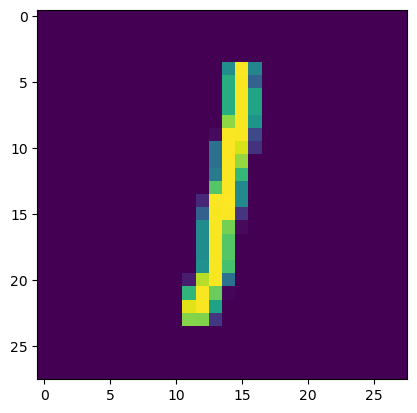

3


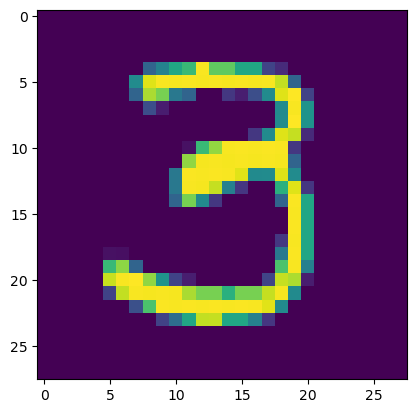

2


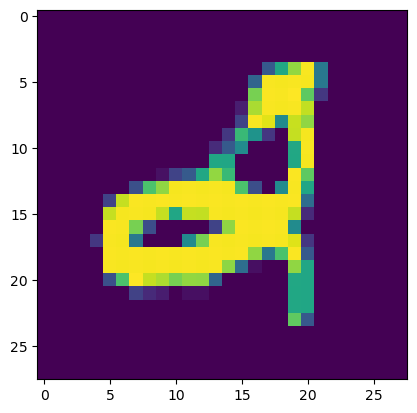

7


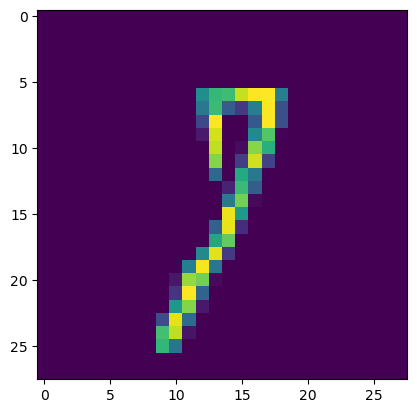

6


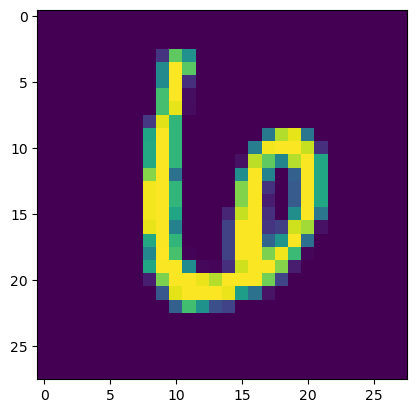

8


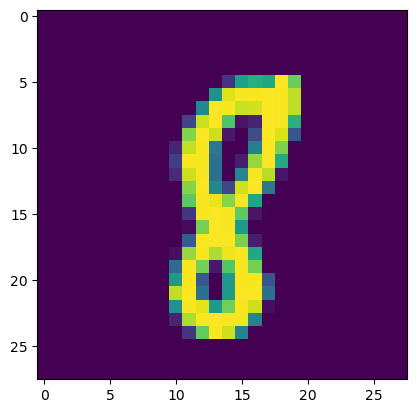

7


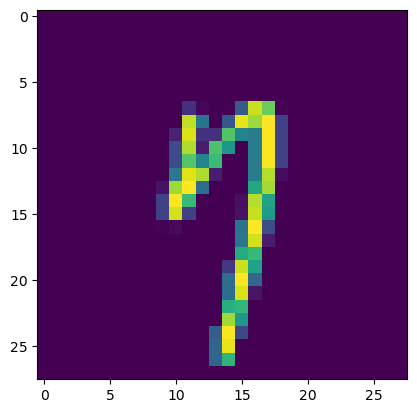

8


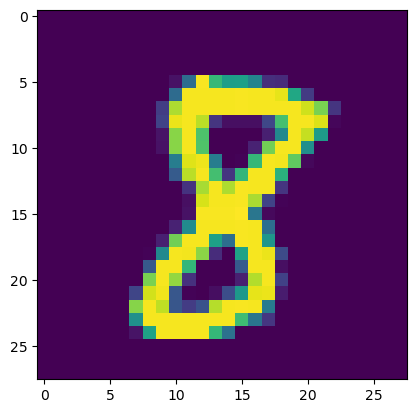

In [5]:
# Explore data
show5(train_loader)
show5(test_loader)

In [6]:
print('Size of train_loader\t=',len(train_loader))
print('Size of test_loader\t=',len(test_loader))
print('Total training samples\t=', train_loader.dataset.data.shape[0])
print('Total testing samples\t=', test_loader.dataset.data.shape[0])
print('Images in one batch\t=',next(iter(train_loader))[0].shape)

Size of train_loader	= 938
Size of test_loader	= 157
Total training samples	= 60000
Total testing samples	= 10000
Images in one batch	= torch.Size([64, 1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # No. of layers in the nodes is taken from `https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627`
        self.layer1 = nn.Linear(784,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64,10)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.log_softmax(self.layer3(x), dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

cuda:0


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
def train(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    device,
    num_epochs=10,
    print_every=250,
):
    n_train_samples = train_loader.dataset.data.shape[0]
    n_test_samples = test_loader.dataset.data.shape[0]

    # Establish a list for our history
    train_loss_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for step, (images, labels) in enumerate(train_loader, start=1):
            # Pass to GPU if available.
            images, labels = images.to(device), labels.to(device)

            # Zero out the gradients of the optimizer
            optimizer.zero_grad()

            # Get the outputs of your model and compute your loss
            logps = model(images)

            loss = criterion(logps, labels)

            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            # ps is not needed to be calculated here, as we are only interested in the indices of max element. Index of max logps = index of max ps
            _, preds = torch.max(logps, dim=1)

            # ps = torch.exp(logps)
            # _, preds = torch.max(ps, dim=1)

            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

            if step % print_every == 0:
                val_loss = 0.0
                val_correct = 0
                model.eval()
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    with torch.no_grad():
                        logps = model(images)
                    loss = criterion(logps, labels)

                    _, preds = torch.max(logps, dim=1)
                    val_correct += (preds == labels).sum().item()
                    val_loss += loss.item()

                print(
                    f'Epoch {epoch + 1} validation accuracy: {100*val_correct/n_test_samples:.2f}% validation loss: {val_loss/len(test_loader):.5f}'
                )
                val_loss_history.append(val_loss / len(test_loader))

        print(
            f'Epoch {epoch + 1} training accuracy  : {100*train_correct/n_train_samples:.2f}% training loss  : {train_loss/len(train_loader):.5f}\n'
        )
        train_loss_history.append(train_loss / len(train_loader))

    return model, train_loss_history, val_loss_history


In [10]:
net, train_loss_history, val_loss_history = train(net,train_loader,test_loader,
 optimizer, criterion, device)


Epoch 1 validation accuracy: 85.42% validation loss: 0.54620
Epoch 1 validation accuracy: 89.81% validation loss: 0.36316
Epoch 1 validation accuracy: 90.50% validation loss: 0.31505
Epoch 1 training accuracy  : 81.72% training loss  : 0.64479

Epoch 2 validation accuracy: 91.53% validation loss: 0.29317
Epoch 2 validation accuracy: 92.22% validation loss: 0.26769
Epoch 2 validation accuracy: 92.92% validation loss: 0.25156
Epoch 2 training accuracy  : 91.56% training loss  : 0.28644

Epoch 3 validation accuracy: 93.40% validation loss: 0.22650
Epoch 3 validation accuracy: 93.75% validation loss: 0.20833
Epoch 3 validation accuracy: 93.35% validation loss: 0.22859
Epoch 3 training accuracy  : 93.38% training loss  : 0.22578

Epoch 4 validation accuracy: 94.95% validation loss: 0.18043
Epoch 4 validation accuracy: 94.29% validation loss: 0.18640
Epoch 4 validation accuracy: 95.10% validation loss: 0.16740
Epoch 4 training accuracy  : 94.71% training loss  : 0.18025

Epoch 5 validation a

Plot the training loss (and validation loss/accuracy, if recorded).

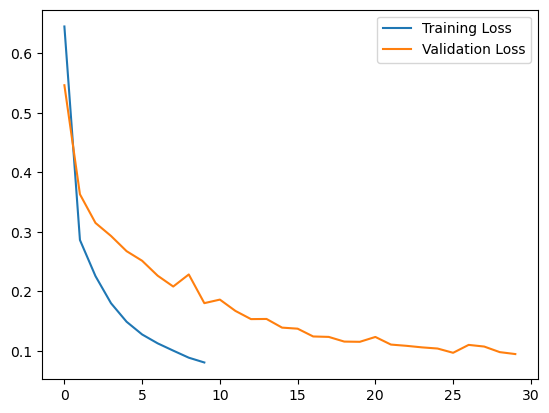

In [11]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
def test(model,test_loader,device):
    val_correct = 0
    n_test_samples = test_loader.dataset.data.shape[0]
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            logps = model(images)

        _, preds = torch.max(logps, dim=1)
        val_correct += (preds == labels).sum().item()
    print(
        f'Validation accuracy: {100*val_correct/n_test_samples:.2f}%'
    )


In [13]:
test(net,test_loader,device)

Validation accuracy: 97.19%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.0005)
net, _, _ = train(net,train_loader,test_loader, optimizer, criterion, device)

Epoch 1 validation accuracy: 97.32% validation loss: 0.08678
Epoch 1 validation accuracy: 97.32% validation loss: 0.08715
Epoch 1 validation accuracy: 97.33% validation loss: 0.08596
Epoch 1 training accuracy  : 98.18% training loss  : 0.06342

Epoch 2 validation accuracy: 97.35% validation loss: 0.08568
Epoch 2 validation accuracy: 97.35% validation loss: 0.08521
Epoch 2 validation accuracy: 97.38% validation loss: 0.08503
Epoch 2 training accuracy  : 98.23% training loss  : 0.06157

Epoch 3 validation accuracy: 97.37% validation loss: 0.08595
Epoch 3 validation accuracy: 97.38% validation loss: 0.08613
Epoch 3 validation accuracy: 97.36% validation loss: 0.08468
Epoch 3 training accuracy  : 98.27% training loss  : 0.06074

Epoch 4 validation accuracy: 97.39% validation loss: 0.08485
Epoch 4 validation accuracy: 97.38% validation loss: 0.08638
Epoch 4 validation accuracy: 97.37% validation loss: 0.08447
Epoch 4 training accuracy  : 98.24% training loss  : 0.06040

Epoch 5 validation a

In [15]:
test(net,test_loader,device)

Validation accuracy: 97.38%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
torch.save(net,'handwritten_digits_classifier.pth')